In [1]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import keras
from keras import layers, models
import pandas as pd

In [2]:
DATA_DIR      = "dataset"
IMG_SIZE      = (512, 512)
BATCH_SIZE    = 32
VAL_SPLIT     = 0.2
SEED          = 123
EPOCHS        = 20
PATIENCE      = 3
AUTOTUNE      = tf.data.AUTOTUNE

In [3]:
train_ds = keras.preprocessing.image_dataset_from_directory(
    DATA_DIR,
    labels="inferred",
    label_mode="binary",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True,
    seed=SEED,
    validation_split=VAL_SPLIT,
    subset="training",
)

val_ds = keras.preprocessing.image_dataset_from_directory(
    DATA_DIR,
    labels="inferred",
    label_mode="binary",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True,
    seed=SEED,
    validation_split=VAL_SPLIT,
    subset="validation",
)

train_ds = train_ds.prefetch(AUTOTUNE)
val_ds   = val_ds.prefetch(AUTOTUNE)

Found 256 files belonging to 2 classes.
Using 205 files for training.
Found 256 files belonging to 2 classes.
Using 51 files for validation.


In [4]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1),
    layers.RandomTranslation(0.1, 0.1),
])

rescale = layers.Rescaling(1./255)

In [5]:
inputs = keras.Input(shape=(*IMG_SIZE, 3))
x = data_augmentation(inputs)
x = rescale(x)

x = layers.Conv2D(32, 3, activation="relu")(x)
x = layers.MaxPool2D(2)(x)

x = layers.Conv2D(64, 3, activation="relu")(x)
x = layers.MaxPool2D(2)(x)

x = layers.Conv2D(128, 3, activation="relu")(x)
x = layers.MaxPool2D(2)(x)

x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs, outputs, name="oak_wilt_detector")
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

model.summary()

Model: "oak_wilt_detector"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 512, 512, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 512, 512, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 512, 512, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 510, 510, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 255, 255, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 253, 253, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 126, 126, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 124, 124, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 62, 62, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 492032)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 492032)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │    31,490,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,583,425 (120.48 MB)

 Trainable params: 31,583,425 (120.48 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
early_stop = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=PATIENCE,
    restore_best_weights=True,
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[early_stop],
)

Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.6110 - loss: 1.7232 - val_accuracy: 0.9216 - val_loss: 0.6926
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.7748 - loss: 0.6924 - val_accuracy: 0.9216 - val_loss: 0.6903
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.7453 - loss: 0.6939 - val_accuracy: 0.9216 - val_loss: 0.6876
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.7920 - loss: 0.6888 - val_accuracy: 0.9216 - val_loss: 0.6847
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.7634 - loss: 0.6874 - val_accuracy: 0.9216 - val_loss: 0.6818
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.8153 - loss: 0.6843 - val_accuracy: 0.9216 - val_loss: 0.6789
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.8248 - loss: 0.6818 - val_accuracy: 0.9216 - val_loss: 0.6761
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.7778 - loss: 0.6815 - val_accuracy: 0.9216 - val_loss: 0.6734
Epoch 9/

In [7]:
out_path = "oakwilt_detector.keras"
model.save(out_path)
print(f"\nModel saved to: {out_path}")


Model saved to: oakwilt_detector.keras


# Analysis

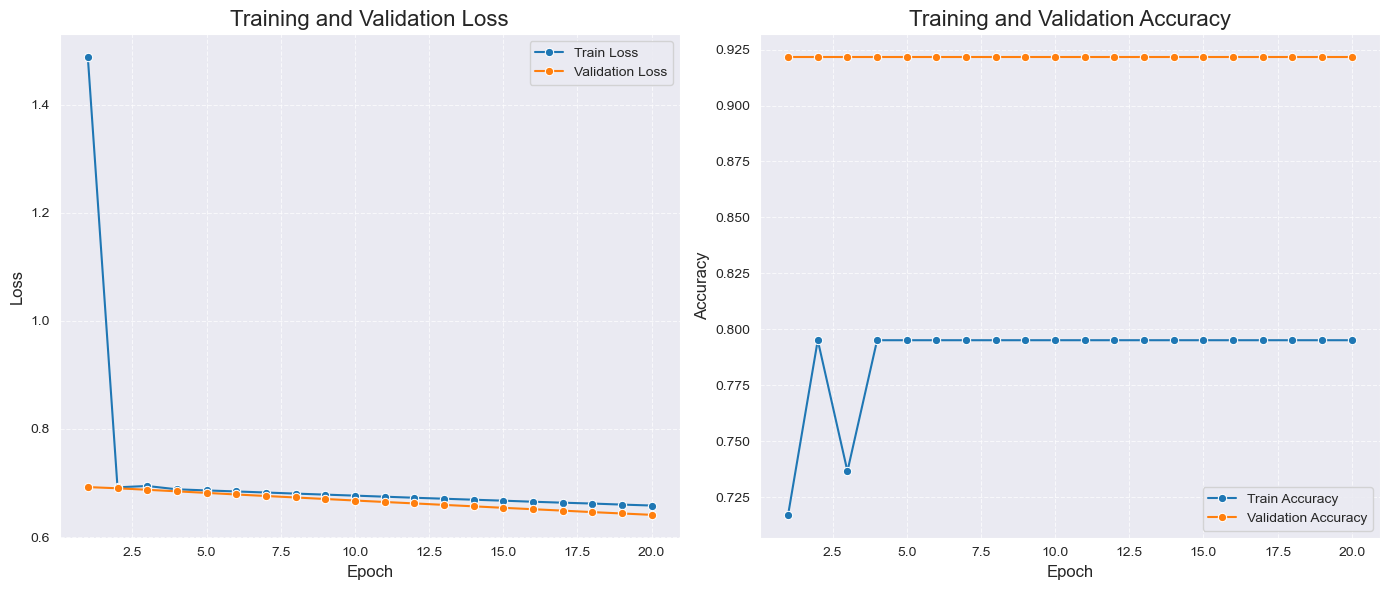

2025-07-10 01:33:46.189565: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 295ms/step

Classification Report:
               precision    recall  f1-score   support

     healthy       0.00      0.00      0.00         4
   unhealthy       0.92      1.00      0.96        47

    accuracy                           0.92        51
   macro avg       0.46      0.50      0.48        51
weighted avg       0.85      0.92      0.88        51


Confusion Matrix:
 [[ 0  4]
 [ 0 47]]


/Users/ruhan/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ruhan/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ruhan/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


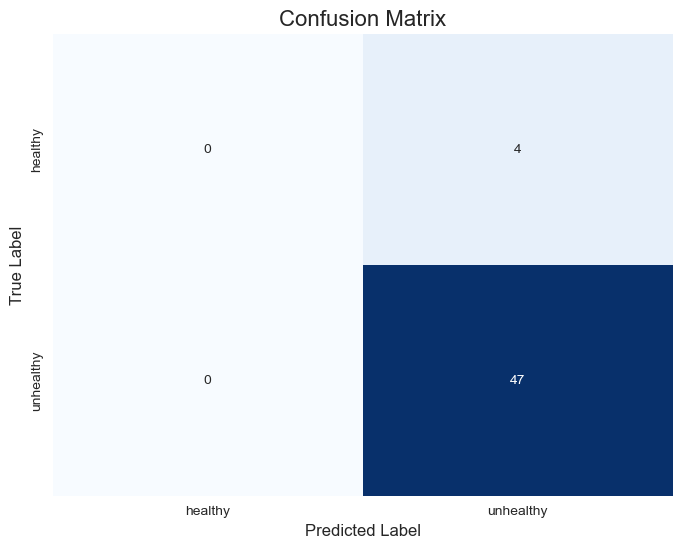

In [8]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import keras
import pandas as pd

def plot_history_seaborn(hist):
    history_df = pd.DataFrame(hist.history)
    history_df['epoch'] = history_df.index + 1

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    sns.lineplot(x='epoch', y='loss', data=history_df, label='Train Loss', ax=axes[0], marker='o')
    sns.lineplot(x='epoch', y='val_loss', data=history_df, label='Validation Loss', ax=axes[0], marker='o')
    axes[0].set_title('Training and Validation Loss', fontsize=16)
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Loss', fontsize=12)
    axes[0].legend(fontsize=10)
    axes[0].grid(True, linestyle='--', alpha=0.7)

    sns.lineplot(x='epoch', y='accuracy', data=history_df, label='Train Accuracy', ax=axes[1], marker='o')
    sns.lineplot(x='epoch', y='val_accuracy', data=history_df, label='Validation Accuracy', ax=axes[1], marker='o')
    axes[1].set_title('Training and Validation Accuracy', fontsize=16)
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Accuracy', fontsize=12)
    axes[1].legend(fontsize=10)
    axes[1].grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

plot_history_seaborn(history)

# Ensure y_true is 1-dimensional
y_true = np.concatenate([y.numpy() for x, y in val_ds], axis=0).flatten()
y_pred_proba = model.predict(val_ds).ravel()
y_pred = (y_pred_proba > 0.5).astype(int)

cr = classification_report(y_true, y_pred, target_names=["healthy", "unhealthy"])
print("\nClassification Report:\n", cr)

cm = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:\n", cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=["healthy", "unhealthy"], yticklabels=["healthy", "unhealthy"])
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.show()